# Imports

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional,Input,GlobalMaxPooling1D,BatchNormalization,Concatenate,Conv1D
#import gensim
import re
import nltk
import string
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertConfig,BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

ImportError: cannot import name 'triu' from 'scipy.linalg' (D:\meeeee\Lib\site-packages\scipy\linalg\__init__.py)

# Normal models


## load data and preprocessing


In [5]:
df = pd.read_csv('/kaggle/input/forum-dataset/train.csv')
df

,SampleID,Discussion,Category
0,1,"Without sitting down and doing it manually, yo...",Sports
1,2,All your Search ends with this link.,STEM
2,3,"No, the program you're using is made to be com...",STEM
3,4,Mike Woicik\n\nThe correct answer is: Mike Woi...,Sports
4,5,"No, but not because of why you might think. Wh...",Politics
...,...,...,...
24984,24985,He's got more pull with the horses than most j...,Sports
24985,24986,Yes he did for a big juicy cheeseburger with f...,Market & Economy
24986,24987,I'm not.,Market & Economy
24987,24988,It is sexual harassment because it is offensiv...,Politics


## Without preprocessing


In [6]:
# df=df.dropna()
# category_mapping = {
#     'Politics': 0,
#     'Sports': 1,
#     'Media': 2,
#     'Market & Economy': 3,
#     'STEM': 4
# }
# df['Discussion'] = df['Discussion'].astype(str)
# df['Category'] = df['Category'].map(category_mapping)
# df=df.drop('SampleID',axis=1)

## With preprocessing

In [7]:
##############Preprocessing##################
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    # Remove NaN values
    if pd.isnull(text):
        return ""
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Tokenize and remove stopwords
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join back into a single string
    return ' '.join(words)

# Apply preprocessing to the 'Discussion' column
df['Discussion']=df['Discussion'].astype(str)
df['Discussion'] = df['Discussion'].dropna().apply(preprocess_text)

# Map categories
category_mapping = {
    'Politics': 0,
    'Sports': 1,
    'Media': 2,
    'Market & Economy': 3,
    'STEM': 4
}
df['Category'] = df['Category'].map(category_mapping)
# Drop the 'SampleID' column
df = df.drop('SampleID', axis=1)
df['Discussion'][0]

'without sitting manually might try scheduling software several one download tried seems job n nhttp www download com league system pro html tag pdp prod'

## Augmentation 

In [ ]:
# def synonym_replacement(row):
#     text = row['Discussion']
#     words = text.split()
#     augmented_text = []
#     for word in words:
#         # Get synonyms for each word
#         synonyms = wordnet.synsets(word)
#         if synonyms:
#             # Replace the word with a synonym
#             synonym = synonyms[0].lemmas()[0].name()
#             augmented_text.append(synonym)
#         else:
#             augmented_text.append(word)
#     return {'augmented': augmented_text, 'category': row['Category']}

# random_sample = df.sample(n=5000, random_state=42)  
# augmented_data = random_sample.apply(synonym_replacement, axis=1)
# augmented_df = pd.DataFrame(augmented_data.tolist())
# augmented_df['augmented'] = augmented_df['augmented'].apply(lambda x: " ".join(x))
# augmented_df.rename(columns={'augmented': 'Discussion', 'category': 'Category'}, inplace=True)
# df = pd.concat([df, augmented_df], ignore_index=True)

## Tokenizer

In [8]:
#####Tokenization########
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 30000
oov_token = "<OOV>"
padding_type = "post"
trunc_type = "post"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['Discussion'])
training_sequences = tokenizer.texts_to_sequences(df['Discussion'])
training_padded = pad_sequences(training_sequences, maxlen=100, padding=padding_type, truncating=trunc_type)
X=np.array(training_padded)
labels = np.array(df['Category'])


## Splitting


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42,stratify=labels)


## Word embedding

In [10]:
# # Function to load GloVe vectors
def load_glove_vectors(filepath):
    embeddings_index = {}
    with open(filepath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector
    return embeddings_index

# Load GloVe embeddings
glove_path = "/kaggle/input/glove6b300dtxt/glove.6B.300d.txt"
glove_vectors = load_glove_vectors(glove_path)
# Parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

# Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate embedding matrix
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

## Ploting Accuracies

In [11]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

## BILSTM

In [12]:
##########################BILSTM################71.444score####30000vocab####300 shape ,input_length100 ####
##################71.5+ score #### Model1 Archi######
bilstmModel = Sequential([
    Input(shape=(100,),dtype=np.int32),
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=100,
              trainable=False),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])
bilstmModel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
bilstmModel.summary()
history = bilstmModel.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 300)            │      14,587,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 512)            │       1,140,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,802,181 (60.28 MB)

 Trainable params: 1,214,981 (4.63 MB)

 Non-trainable params: 14,587,200 (55.65 MB)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 144s 892ms/step - accuracy: 0.5263 - loss: 1.1987 - val_accuracy: 0.6895 - val_loss: 0.8389
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 890ms/step - accuracy: 0.6723 - loss: 0.8792 - val_accuracy: 0.6993 - val_loss: 0.7918
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 884ms/step - accuracy: 0.6926 - loss: 0.8125 - val_accuracy: 0.7223 - val_loss: 0.7515
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 893ms/step - accuracy: 0.7098 - loss: 0.7793 - val_accuracy: 0.7261 - val_loss: 0.7420
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 149s 940ms/step - accuracy: 0.7193 - loss: 0.7549 - val_accuracy: 0.7315 - val_loss: 0.7351
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 894ms/step - accuracy: 0.7230 - loss: 0.7253 - val_accuracy: 0.7257 - val_loss: 0.7276
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 146s 930ms/step - accuracy: 0.7354 - loss: 0.6975 - val_accuracy: 0.7281 - val_loss: 0.7273
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 880ms/step - accuracy: 0.7449 -

In [13]:
bilstmModel.evaluate(x_val,y_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7407 - loss: 0.7111


[0.7240527272224426, 0.7314925789833069]

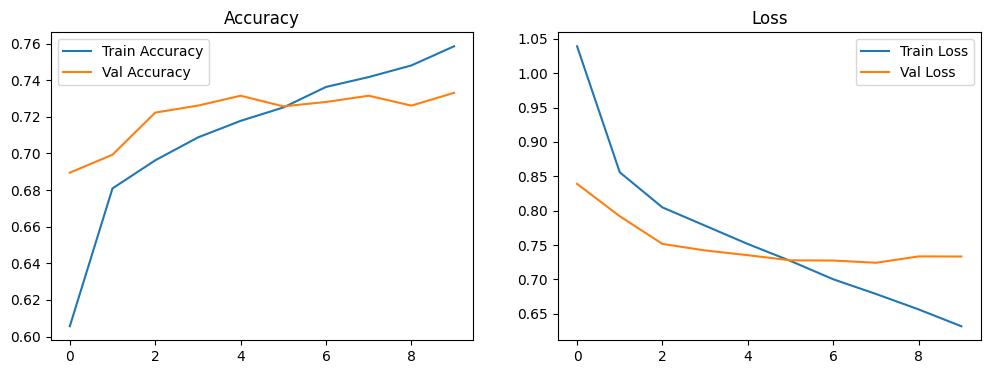

In [14]:
plot_history(history)

### Save Model

In [15]:
bilstmModel.save('bilstmModel.h5')

In [16]:
savedModelBILSTM =tf.keras.models.load_model('bilstmModel.h5')

In [17]:
savedModelBILSTM.predict(x_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step


array([[1.95961469e-03, 5.18300039e-05, 9.63860075e-05, 9.95154619e-01,
        2.73747393e-03],
       [3.10469922e-02, 2.47105472e-02, 1.29366685e-02, 8.75971854e-01,
        5.53340018e-02],
       [5.47379434e-01, 6.01143166e-02, 3.89478244e-02, 2.93853730e-01,
        5.97045198e-02],
       ...,
       [4.03810054e-01, 2.35276759e-01, 1.99208722e-01, 1.39225587e-01,
        2.24788971e-02],
       [1.47980437e-01, 3.14346045e-01, 2.69076794e-01, 1.77611649e-01,
        9.09851342e-02],
       [2.76428759e-01, 6.48697242e-02, 2.78219786e-02, 5.06716013e-01,
        1.24163456e-01]], dtype=float32)

## GRU

In [18]:
########################Archi2#################
gruModel=Sequential([
    Input(shape=(100,),dtype=np.int32),
    Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=100,  # Adjust the input length to match your data
    trainable=False),
    GRU(256,return_sequences=True),
    Dropout(0.3),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')

])

In [19]:
gruModel.summary()
gruModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
historyy=gruModel.fit(x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 300)            │      14,587,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 256)            │         428,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,057,221 (57.44 MB)

 Trainable params: 470,021 (1.79 MB)

 Non-trainable params: 14,587,200 (55.65 MB)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 460ms/step - accuracy: 0.5094 - loss: 1.1955 - val_accuracy: 0.7111 - val_loss: 0.8152
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 71s 452ms/step - accuracy: 0.6936 - loss: 0.8301 - val_accuracy: 0.7135 - val_loss: 0.7916
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 456ms/step - accuracy: 0.7149 - loss: 0.7680 - val_accuracy: 0.7199 - val_loss: 0.7539
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 71s 450ms/step - accuracy: 0.7358 - loss: 0.7123 - val_accuracy: 0.7299 - val_loss: 0.7368
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 71s 453ms/step - accuracy: 0.7510 - loss: 0.6673 - val_accuracy: 0.7243 - val_loss: 0.7325
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 449ms/step - accuracy: 0.7713 - loss: 0.6143 - val_accuracy: 0.7253 - val_loss: 0.7345
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 454ms/step - accuracy: 0.7889 - loss: 0.5714 - val_accuracy: 0.7151 - val_loss: 0.7728
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 479ms/step - accuracy: 0.8095 - loss: 0

In [20]:
gruModel.evaluate(x_val,y_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7327 - loss: 0.7220


[0.7325435876846313, 0.7242897152900696]

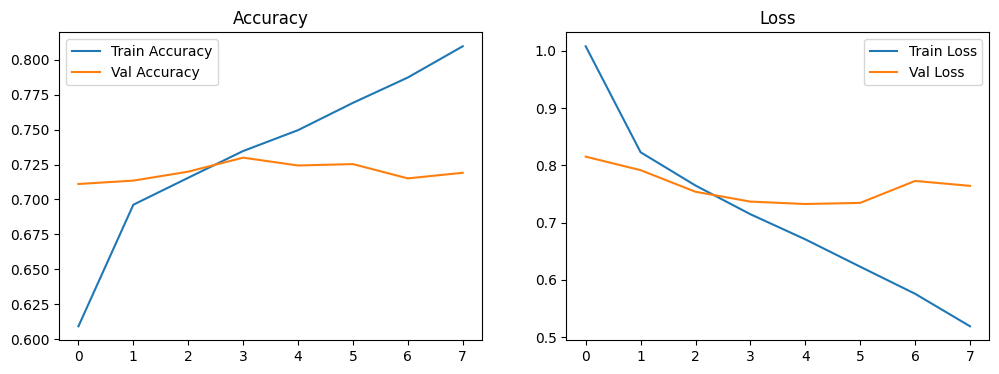

In [21]:
plot_history(historyy)

### Save model

In [22]:
gruModel.save('gruModel.h5')

In [23]:
savedModelGRU =tf.keras.models.load_model('gruModel.h5')

In [24]:
savedModelGRU.predict(x_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step


array([[0.01831329, 0.00389661, 0.00192465, 0.9718285 , 0.00403696],
       [0.13837108, 0.07836799, 0.06519436, 0.68544805, 0.03261854],
       [0.74891603, 0.03446022, 0.05329577, 0.14391182, 0.01941621],
       ...,
       [0.24171723, 0.30967867, 0.24501078, 0.1633648 , 0.04022855],
       [0.1438904 , 0.27182007, 0.27843493, 0.19933373, 0.10652085],
       [0.42149654, 0.15603426, 0.02551411, 0.32709756, 0.0698575 ]],
      dtype=float32)

# Test Submission 

In [ ]:
test_df = pd.read_csv('/kaggle/input/traintest/test.csv')
df['Discussion']=df['Discussion'].astype(str)
test_df['Discussion'] = test_df['Discussion'].apply(preprocess_text)

In [ ]:
sequences_test = tokenizer.texts_to_sequences(test_df['Discussion'])
padded_sequences_test = pad_sequences(sequences_test, maxlen=100, padding='post')

X_test = np.array(padded_sequences_test)
# BILISTM TEST
predictions = savedModelBILSTM.predict(X_test)

In [ ]:
predicted_class = predictions.argmax(axis=-1)
predicted_class
len(predicted_class)

In [ ]:
n_submit = pd.DataFrame({
    "SampleID": test_df["SampleID"],  
    "Category": predicted_class  
})
n_submit.to_csv("/kaggle/working/bilstmagrglo.csv", index = False)

# Transformers 

In [2]:
df = pd.read_csv('/kaggle/input/forum-dataset/train.csv')

In [3]:
# Preprocessing
df=df.dropna()
category_mapping = {
    'Politics': 0,
    'Sports': 1,
    'Media': 2,
    'Market & Economy': 3,
    'STEM': 4
}
df['Discussion'] = df['Discussion'].astype(str)
df['Category'] = df['Category'].map(category_mapping)
df = df.drop('SampleID', axis=1)

## Transformer

In [27]:
from tensorflow.keras.layers import (
    Layer, Input, Dense, MultiHeadAttention, Reshape,
    LayerNormalization, Dropout, Embedding, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW

inputs = Input(shape=(100,))

x = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=100,
    trainable=False
)(inputs)


x = MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.2)(x, x)

x = LayerNormalization()(x + x)


x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(5, activation='softmax')(x)
T_Model = Model(inputs=inputs, outputs=outputs)
optimizer = AdamW(learning_rate=0.0005, weight_decay=1e-5)
T_Model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
T_Model.summary()

history_transformer = T_Model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 100, 300)       │     14,587,200 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 300)       │        308,268 │ embedding_2[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 300)       │              0 │ multi_head_attention[… │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 300)       │            600 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 30000)          │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │      1,920,064 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │            325 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,816,457 (64.15 MB)

 Trainable params: 2,229,257 (8.50 MB)

 Non-trainable params: 14,587,200 (55.65 MB)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 519ms/step - accuracy: 0.5502 - loss: 1.2601 - val_accuracy: 0.6575 - val_loss: 0.9092
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 516ms/step - accuracy: 0.6163 - loss: 1.0013 - val_accuracy: 0.6787 - val_loss: 0.8701
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.6420 - loss: 0.9566 - val_accuracy: 0.6931 - val_loss: 0.8536
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 508ms/step - accuracy: 0.6607 - loss: 0.8992 - val_accuracy: 0.6959 - val_loss: 0.8486
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 506ms/step - accuracy: 0.6611 - loss: 0.8954 - val_accuracy: 0.7091 - val_loss: 0.8152
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 535ms/step - accuracy: 0.6761 - loss: 0.8472 - val_accuracy: 0.7055 - val_loss: 0.8074
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 507ms/step - accuracy: 0.6898 - loss: 0.8309 - val_accuracy: 0.7151 - val_loss: 0.7994
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 497ms/step - accuracy: 0.6957 - loss: 0

In [28]:
T_Model.evaluate(x_val,y_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7087 - loss: 0.8291


[0.8498719930648804, 0.6952781081199646]

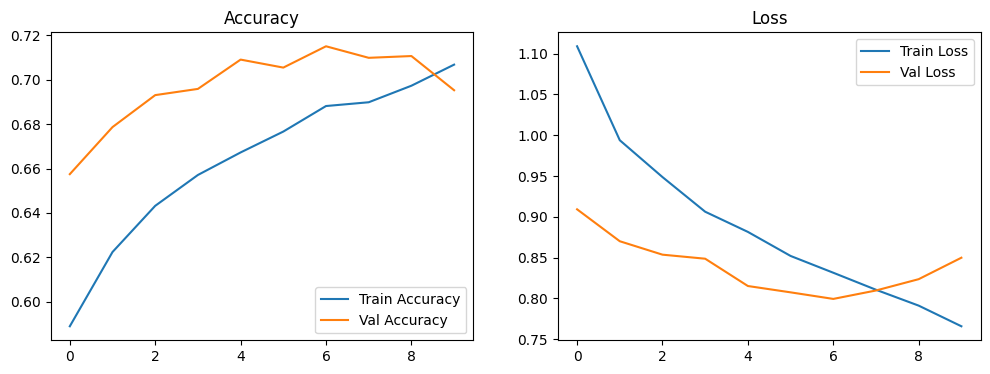

In [29]:
plot_history(history_transformer)

## Bert 

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Embedding, MultiHeadAttention, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model

class PositionEmbeddingLayer(Layer):
    def __init__(self, max_length, d_model):
        super(PositionEmbeddingLayer, self).__init__()
        self.max_length = max_length
        self.d_model = d_model
        self.position_embeddings = Embedding(input_dim=self.max_length, output_dim=self.d_model)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.position_embeddings(position_ids)
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        position_embeddings = tf.tile(position_embeddings, [tf.shape(inputs)[0], 1, 1])
        return position_embeddings


def bert_encoder_block(x, d_model, n_heads, d_ff, dropout=0.1, attention_mask=None):
    attention = MultiHeadAttention(
        num_heads=n_heads,
        key_dim=d_model // n_heads,
        dropout=dropout
    )(x, x, x, attention_mask=attention_mask)
    attention = Dropout(dropout)(attention)
    out1 = LayerNormalization()(x + attention)
    
    ffn_output = Dense(d_ff, activation='gelu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    
    return LayerNormalization()(out1 + ffn_output)

def build_bert_for_sequence_classification(n_layers, d_model, n_heads, d_ff, vocab_size, max_length, num_classes, dropout=0.1):
    # Input layers
    input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    token_type_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
    
    # Embeddings
    word_embeddings = Embedding(vocab_size, d_model)(input_ids)
    position_embeddings = PositionEmbeddingLayer(max_length, d_model)(input_ids)
    token_type_embeddings = Embedding(2, d_model)(token_type_ids)
    
    x = word_embeddings + position_embeddings + token_type_embeddings
    x = LayerNormalization()(x)
    x = Dropout(dropout)(x)
    
    # Transformer blocks
    for _ in range(n_layers):
        x = bert_encoder_block(x, d_model, n_heads, d_ff, dropout, attention_mask)
    
    # Classification head
    cls_token_output = x[:, 0, :]
    x = Dropout(dropout)(cls_token_output)
    logits = Dense(num_classes)(x)
    
    # Create model
    model = Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=logits,
        name="BERT_Sequence_Classifier"
    )
    return model
# Initialize parameters
MAX_LEN = 128
BATCH_SIZE = 32
N_LAYERS = 12
D_MODEL = 768
N_HEADS = 12
D_FF = 3072
VOCAB_SIZE = 30522
NUM_CLASSES = 5
DROPOUT = 0.1

# Build model
model1 = build_bert_for_sequence_classification(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    vocab_size=VOCAB_SIZE,
    max_length=MAX_LEN,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
)

# Print model summary
model1.summary()

Model: "BERT_Sequence_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 128, 768)       │     23,440,896 │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding_layer  │ (None, 128, 768)       │         98,304 │ input_ids[0][0]        │
│ (PositionEmbeddingLayer)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_type_ids            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 768)       │              0 │ embedding[0][0],       │
│                           │                        │                │ position_embedding_la… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 128, 768)       │          1,536 │ token_type_ids[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 768)       │              0 │ add[0][0],             │
│                           │                        │                │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 768)       │          1,536 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 768)       │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 768)       │      2,362,368 │ dropout[0][0],         │
│ (MultiHeadAttention)      │                        │                │ dropout[0][0],         │
│                           │                        │                │ dropout[0][0],         │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 768)       │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 128, 768)       │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 768)       │          1,536 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 108,600,581 (414.28 MB)

 Trainable params: 108,600,581 (414.28 MB)

 Non-trainable params: 0 (0.00 B)

# Roberta

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.models import Model
from transformers import RobertaTokenizer


# Position embedding layer
def position_embedding_layer(inputs, max_length, d_model):
    def compute_position_embeddings(inputs):
        position_embeddings = Embedding(max_length, d_model)(tf.range(start=0, limit=tf.shape(inputs)[1], delta=1))
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        return tf.tile(position_embeddings, [tf.shape(inputs)[0], 1, 1])

    return Lambda(compute_position_embeddings)(inputs)

# RoBERTa encoder block
def roberta_encoder_block(x, d_model, n_heads, d_ff, dropout=0.1, attention_mask=None):
    attention = MultiHeadAttention(
        num_heads=n_heads,
        key_dim=d_model // n_heads,
        dropout=dropout
    )(x, x, x, attention_mask=attention_mask)
    attention = Dropout(dropout)(attention)
    out1 = LayerNormalization()(x + attention)
    
    ffn_output = Dense(d_ff, activation='gelu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    
    return LayerNormalization()(out1 + ffn_output)

# Build RoBERTa model for sequence classification
def build_roberta_for_sequence_classification(
    n_layers, d_model, n_heads, d_ff, vocab_size, max_length, num_classes, dropout=0.1
):
    # Input layers
    input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
    
    # Embeddings
    word_embeddings = Embedding(vocab_size, d_model)(input_ids)
    position_embeddings = position_embedding_layer(input_ids, max_length, d_model)
    x = word_embeddings + position_embeddings
    x = LayerNormalization()(x)
    x = Dropout(dropout)(x)
    
    # Transformer blocks
    for _ in range(n_layers):
        x = roberta_encoder_block(x, d_model, n_heads, d_ff, dropout, attention_mask)
    
    # Classification head with two dense layers and tanh activation
    cls_token_output = x[:, 0, :]
    x = Dropout(dropout)(cls_token_output)
    x = Dense(d_model, activation='tanh')(x)  # First Dense layer with tanh activation
    x = Dropout(dropout)(x)
    logits = Dense(num_classes)(x)  # Second Dense layer for final output
    
    # Create model
    model = Model(
        inputs=[input_ids, attention_mask],
        outputs=logits,
        name="RoBERTa_Sequence_Classifier"
    )
    return model


# Build model
MAX_LEN = 128  # Using your original max length
BATCH_SIZE = 32  # Your original batch size
N_LAYERS = 12
D_MODEL = 768
N_HEADS = 12
D_FF = 3072
NUM_CLASSES = 5
DROPOUT = 0.1

model2 = build_roberta_for_sequence_classification(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    vocab_size=50265,
    max_length=MAX_LEN,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
)

# Print model summary
model2.summary()

Model: "RoBERTa_Sequence_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 128, 768)       │     38,603,520 │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 768)       │              0 │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 128, 768)       │              0 │ embedding_3[0][0],     │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_25    │ (None, 128, 768)       │          1,536 │ add_26[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 128, 768)       │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 128, 768)       │      2,362,368 │ dropout_38[0][0],      │
│ (MultiHeadAttention)      │                        │                │ dropout_38[0][0],      │
│                           │                        │                │ dropout_38[0][0],      │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_40 (Dropout)      │ (None, 128, 768)       │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)              │ (None, 128, 768)       │              0 │ dropout_38[0][0],      │
│                           │                        │                │ dropout_40[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 128, 768)       │          1,536 │ add_27[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 128, 3072)      │      2,362,368 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 128, 768)       │      2,360,064 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_41 (Dropout)      │ (None, 128, 768)       │              0 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_28 (Add)              │ (None, 128, 768)       │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_41[0][0]       │
├──────────────────────

 Total params: 124,253,957 (473.99 MB)

 Trainable params: 124,253,957 (473.99 MB)

 Non-trainable params: 0 (0.00 B)

# Ensemble models

In [6]:
from transformers import RobertaTokenizer, BertTokenizer
import torch

# Tokenizers
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_texts(tokenizer,texts, max_len):
    input_ids = []
    attention_masks = []
    
    for sent in texts:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

MAX_LEN = 128
sentences = df.Discussion.values
labels = torch.tensor(df.Category.values)

# Tokenize for both models
roberta_input_ids, roberta_attention_masks = tokenize_texts(roberta_tokenizer, sentences, MAX_LEN)
bert_input_ids, bert_attention_masks = tokenize_texts(bert_tokenizer, sentences, MAX_LEN)

# Split the dataset
from sklearn.model_selection import train_test_split

def split_data(input_ids, attention_masks, labels):
    train_inputs, val_inputs, train_labels, val_labels = train_test_split(
        input_ids, labels, random_state=2021, test_size=0.1
    )
    train_masks, val_masks, _, _ = train_test_split(
        attention_masks, input_ids, random_state=2021, test_size=0.1
    )
    return train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels

# Split for RoBERTa
roberta_train_inputs, roberta_val_inputs, roberta_train_masks, roberta_val_masks, roberta_train_labels, roberta_val_labels = split_data(
    roberta_input_ids, roberta_attention_masks, labels
)
# Split for BERT
bert_train_inputs, bert_val_inputs, bert_train_masks, bert_val_masks, bert_train_labels, bert_val_labels = split_data(
    bert_input_ids, bert_attention_masks, labels
)

from transformers import RobertaForSequenceClassification, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import get_scheduler
from tqdm import trange
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 4
learning_rate = 2e-5

# Function to train a model
def train_model(model, train_dataloader, optimizer, scheduler):
    model.to(device)
    model.train()
    
    for epoch in trange(epochs, desc="Epochs"):
        total_loss = 0
        
        for batch in train_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        print(f"Epoch Loss: {total_loss / len(train_dataloader):.4f}")
    return model

# Train RoBERTa
roberta_train_data = TensorDataset(roberta_train_inputs, roberta_train_masks, roberta_train_labels)
roberta_train_dataloader = DataLoader(roberta_train_data, sampler=RandomSampler(roberta_train_data), batch_size=batch_size)

roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)
optimizer = AdamW(roberta_model.parameters(), lr=learning_rate, eps=1e-8)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(roberta_train_dataloader) * epochs)
roberta_model = train_model(roberta_model, roberta_train_dataloader, optimizer, scheduler)

# Train BERT
bert_train_data = TensorDataset(bert_train_inputs, bert_train_masks, bert_train_labels)
bert_train_dataloader = DataLoader(bert_train_data, sampler=RandomSampler(bert_train_data), batch_size=batch_size)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
optimizer = AdamW(bert_model.parameters(), lr=learning_rate, eps=1e-8)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(bert_train_dataloader) * epochs)
bert_model = train_model(bert_model, bert_train_dataloader, optimizer, scheduler)
# Function to get predictions
def get_predictions(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            predictions.append(logits.cpu().numpy())

    return np.concatenate(predictions, axis=0)

# Validation dataloaders
roberta_val_data = TensorDataset(roberta_val_inputs, roberta_val_masks, roberta_val_labels)
roberta_val_dataloader = DataLoader(roberta_val_data, sampler=SequentialSampler(roberta_val_data), batch_size=batch_size)

bert_val_data = TensorDataset(bert_val_inputs, bert_val_masks, bert_val_labels)
bert_val_dataloader = DataLoader(bert_val_data, sampler=SequentialSampler(bert_val_data), batch_size=batch_size)

# Get logits
roberta_logits = get_predictions(roberta_model, roberta_val_dataloader)
bert_logits = get_predictions(bert_model, bert_val_dataloader)

# Weighted average
weights = [1.0, 0.5]  # Adjust based on performance
ensemble_logits = np.average([roberta_logits, bert_logits], axis=0, weights=weights)
ensemble_predictions = np.argmax(ensemble_logits, axis=1)

# Calculate accuracy
label_ids = roberta_val_labels.numpy()
accuracy = np.sum(ensemble_predictions == label_ids) / len(label_ids)
print(f"Ensemble Validation Accuracy: {accuracy:.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epochs:  25%|██▌       | 1/4 [07:36<22:48, 456.12s/it]

Epoch Loss: 0.7667


Epochs:  50%|█████     | 2/4 [15:19<15:20, 460.47s/it]

Epoch Loss: 0.5607


Epochs:  75%|███████▌  | 3/4 [23:03<07:42, 462.06s/it]

Epoch Loss: 0.4530


Epochs: 100%|██████████| 4/4 [30:47<00:00, 461.82s/it]

Epoch Loss: 0.3789


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epochs:  25%|██▌       | 1/4 [07:36<22:48, 456.03s/it]

Epoch Loss: 0.7789


Epochs:  50%|█████     | 2/4 [15:12<15:12, 456.15s/it]

Epoch Loss: 0.5281


Epochs:  75%|███████▌  | 3/4 [22:48<07:36, 456.13s/it]

Epoch Loss: 0.3910


Epochs: 100%|██████████| 4/4 [30:24<00:00, 456.15s/it]

Epoch Loss: 0.2932


Ensemble Validation Accuracy: 0.7939


In [8]:
# Save RoBERTa model weights
torch.save(roberta_model.state_dict(), 'roberta_model_weights.pth')
# Save BERT model weights
torch.save(bert_model.state_dict(), 'bert_model_weights.pth')

In [13]:
from transformers import BertTokenizer, BertConfig,BertModel
from transformers import RobertaForSequenceClassification, BertForSequenceClassification, AdamW
from transformers import RobertaTokenizer, BertTokenizer
import torch

In [15]:
test_df = pd.read_csv('/kaggle/input/forum-dataset/test.csv')
test_df['Discussion'] = test_df['Discussion'].astype(str)

# Tokenize test data for RoBERTa
roberta_test_input_ids, roberta_test_attention_masks = tokenize_texts(
    roberta_tokenizer, test_df['Discussion'].values, MAX_LEN
)

# Tokenize test data for BERT
bert_test_input_ids, bert_test_attention_masks = tokenize_texts(
    bert_tokenizer, test_df['Discussion'].values, MAX_LEN
)

# Create dataloaders
roberta_test_data = TensorDataset(roberta_test_input_ids, roberta_test_attention_masks)
roberta_test_dataloader = DataLoader(roberta_test_data, sampler=SequentialSampler(roberta_test_data), batch_size=batch_size)

bert_test_data = TensorDataset(bert_test_input_ids, bert_test_attention_masks)
bert_test_dataloader = DataLoader(bert_test_data, sampler=SequentialSampler(bert_test_data), batch_size=batch_size)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/forum-dataset/test.csv'

In [11]:
# Get predictions for the test data
roberta_test_logits = get_predictions(roberta_model, roberta_test_dataloader)
bert_test_logits = get_predictions(bert_model, bert_test_dataloader)

# Weighted average of logits
test_ensemble_logits = np.average([roberta_test_logits, bert_test_logits], axis=0, weights=weights)

# Final predictions
test_predictions = np.argmax(test_ensemble_logits, axis=1)

In [12]:
submit = pd.DataFrame({
    "SampleID": test_df["SampleID"],  # Ensure 'SampleID' exists in test_df
    "Category": test_predictions  # Predictions as category labels
})

# Display the first few rows of the submission DataFrame
print(submit.head())

# Save to a CSV file
submit.to_csv("finalfinal5.csv", index=False)

   SampleID  Category
0         1         3
1         2         0
2         3         1
3         4         4
4         5         3


# Test Script

In [41]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
batch_size = 32

MAX_LEN = 128
# Tokenization function
def tokenize_texts(tokenizer,texts, max_len):
    input_ids = []
    attention_masks = []
    
    for sent in texts:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [43]:
def get_predictions(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            predictions.append(logits.cpu().numpy())

    return np.concatenate(predictions, axis=0)

In [45]:
test_df = pd.read_csv('WednesdayTest.csv')
test_df['Discussion'] = test_df['Discussion'].astype(str)

# Tokenize test data for RoBERTa
roberta_test_input_ids, roberta_test_attention_masks = tokenize_texts(
    roberta_tokenizer, test_df['Discussion'].values, MAX_LEN
)

# Tokenize test data for BERT
bert_test_input_ids, bert_test_attention_masks = tokenize_texts(
    bert_tokenizer, test_df['Discussion'].values, MAX_LEN
)

# Create dataloaders
roberta_test_data = TensorDataset(roberta_test_input_ids, roberta_test_attention_masks)
roberta_test_dataloader = DataLoader(roberta_test_data, sampler=SequentialSampler(roberta_test_data), batch_size=batch_size)

bert_test_data = TensorDataset(bert_test_input_ids, bert_test_attention_masks)
bert_test_dataloader = DataLoader(bert_test_data, sampler=SequentialSampler(bert_test_data), batch_size=batch_size)


# Load RoBERTa model weights
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)
roberta_model.load_state_dict(torch.load('roberta_model_weights.pth'))
roberta_model.to(device)

# Load BERT model weights
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
bert_model.load_state_dict(torch.load('bert_model_weights.pth'))
bert_model.to(device)

# Get predictions for the test data
roberta_test_logits = get_predictions(roberta_model, roberta_test_dataloader)
bert_test_logits = get_predictions(bert_model, bert_test_dataloader)

# Weighted average of logits
test_ensemble_logits = np.average([roberta_test_logits, bert_test_logits], axis=0, weights=weights)

# Final predictions
test_predictions = np.argmax(test_ensemble_logits, axis=1)



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Nardeen\AppData\Local\Temp\ipykernel_230324\1766930758.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mod

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [21]:
submit = pd.DataFrame({
    "SampleID": test_df["SampleID"],  # Ensure 'SampleID' exists in test_df
    "Category": test_predictions  # Predictions as category labels
})

# Display the first few rows of the submission DataFrame
print(submit.head())

# Save to a CSV file
submit.to_csv("Test_Script_bert_roberta.csv", index=False)

   SampleID  Category
0         1         3
1         2         0
2         3         1
3         4         4
4         5         3
